This notebook uses the q_learning_lib.py to perform Q-learning on tic tac toe.

A variation of different hyperparameters are tried, against many different cases.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import q_learning_lib as qlb
import json
import os

Assuming alpha = 0.1 and tau = e, lets record what happens in each of the 4 cases of training (optimal, non optimal, x, o)

In [3]:
NUMBER_OF_BATCHES = 1000
BATCH_SIZE = 10

In [4]:
def make_alpha(rate_val):
    """Function factorie for creating different alpha functions"""
    def alpha(turn):

        #return rate_val * (BATCH_SIZE * NUMBER_OF_BATCHES - turn) / (NUMBER_OF_BATCHES * BATCH_SIZE)
        return 0.5 / (1 + rate_val * turn) 

    return alpha

def make_tau(rate_val):
    """Function factorie for creating different tau functions"""
    def tau(turn):
        #return 1 + rate_val * (turn) / (NUMBER_OF_BATCHES * BATCH_SIZE) 
        return 1 + (rate_val - 1) * ((turn/(NUMBER_OF_BATCHES * BATCH_SIZE))**3)
    return tau

def record_params(results, filename):

    df = pd.DataFrame(results[::-1], columns=['o_win', 'draw', 'x_win'])

    # Save to CSV (index=False prevents it from adding a row-number column)
    df.to_csv(filename, index=False)

In [ ]:
alpha_rates = np.linspace(0.000001, 0.001, 10)
tau_values = np.linspace(1000, 1000000, 10)
tau_values

array([  1000.,  12000.,  23000.,  34000.,  45000.,  56000.,  67000.,
        78000.,  89000., 100000.])

In [6]:
def try_different_hyperparams(alpha_rates, tau_values, player, strategy, folder=""):
    """this functions tries a variation of different hyperparameters
    results from every single iteration are saved in a .csv file
    how alpha params, tau values affect the final winrates is recorded in a pandas df and also saved to a file """
 
    df_list = [] #will be turned to a df later
    
    for a, alpha_rate in enumerate(alpha_rates): 
        for b, tau_value in enumerate(tau_values):

            #trains
            Q_Table_x_optimal, results = qlb.perform_training(player, strategy, NUMBER_OF_BATCHES, BATCH_SIZE, False, make_alpha(alpha_rate), make_tau(tau_value))

            results = results/(BATCH_SIZE * 200)
        
            #records the results
            filename = f"parameter_results/{player}_vs_{strategy}/_opponent_alpha_{alpha_rate}_tau_{tau_value}.csv"
            record_params(results, filename)

            
            #records end winrates vs hyperparams
            o_winrate = np.mean(results[:, 0][-5:])
            drawrate = np.mean(results[:, 1][-5:])
            x_winrate = np.mean(results[:, 2][-5:])
            new_results = {'alpha_rate': alpha_rate, 'tau_rate': tau_value, 'o_winrate': o_winrate, 'drawrate': drawrate, 'x_winrate': x_winrate}
            df_list.append(new_results)
            #print(f"alpha rate = {alpha_rate}, tau rate = {tau_value}, end winrates = {end_winrate}")
            print(f"{player}_vs_{strategy}: {((a * 10 + b + 1)/(len(alpha_rates) * len(tau_values))) * 100:.2f}%")
            print(f"'alpha_rate' {alpha_rate}, 'tau_rate': {tau_value}, 'o_winrate': {o_winrate:.3f}, 'drawrate': {drawrate:.3f}, 'x_winrate': {x_winrate:.3f}")

    df = pd.DataFrame(df_list) 
    df.to_csv(f"parameter_results/{player}_vs_{strategy}/hyperparams.csv", index=False)

In [ ]:
try_different_hyperparams(alpha_rates, tau_values, 'x', 'perfect')
try_different_hyperparams(alpha_rates, tau_values, 'o', 'perfect')
try_different_hyperparams(alpha_rates, tau_values, 'x', 'random')
try_different_hyperparams(alpha_rates, tau_values, 'o', 'random')

x_vs_perfect: 1.00%
'alpha_rate' 1e-05, 'tau_rate': 1000.0, 'o_winrate': 0.244, 'drawrate': 0.756, 'x_winrate': 0.000
x_vs_perfect: 2.00%
'alpha_rate' 1e-05, 'tau_rate': 12000.0, 'o_winrate': 0.140, 'drawrate': 0.860, 'x_winrate': 0.000
x_vs_perfect: 3.00%
'alpha_rate' 1e-05, 'tau_rate': 23000.0, 'o_winrate': 0.125, 'drawrate': 0.875, 'x_winrate': 0.000
x_vs_perfect: 4.00%
'alpha_rate' 1e-05, 'tau_rate': 34000.0, 'o_winrate': 0.116, 'drawrate': 0.884, 'x_winrate': 0.000
x_vs_perfect: 5.00%
'alpha_rate' 1e-05, 'tau_rate': 45000.0, 'o_winrate': 0.113, 'drawrate': 0.887, 'x_winrate': 0.000
x_vs_perfect: 6.00%
'alpha_rate' 1e-05, 'tau_rate': 56000.0, 'o_winrate': 0.108, 'drawrate': 0.892, 'x_winrate': 0.000
x_vs_perfect: 7.00%
'alpha_rate' 1e-05, 'tau_rate': 67000.0, 'o_winrate': 0.109, 'drawrate': 0.891, 'x_winrate': 0.000
x_vs_perfect: 8.00%
'alpha_rate' 1e-05, 'tau_rate': 78000.0, 'o_winrate': 0.104, 'drawrate': 0.897, 'x_winrate': 0.000
x_vs_perfect: 9.00%
'alpha_rate' 1e-05, 'tau_rate

In [8]:
df = pd.read_csv('parameter_results/x_vs_perfect/hyperparams.csv')

Text(0.5, 1.0, 'Max Winrate achieved 89.76%')

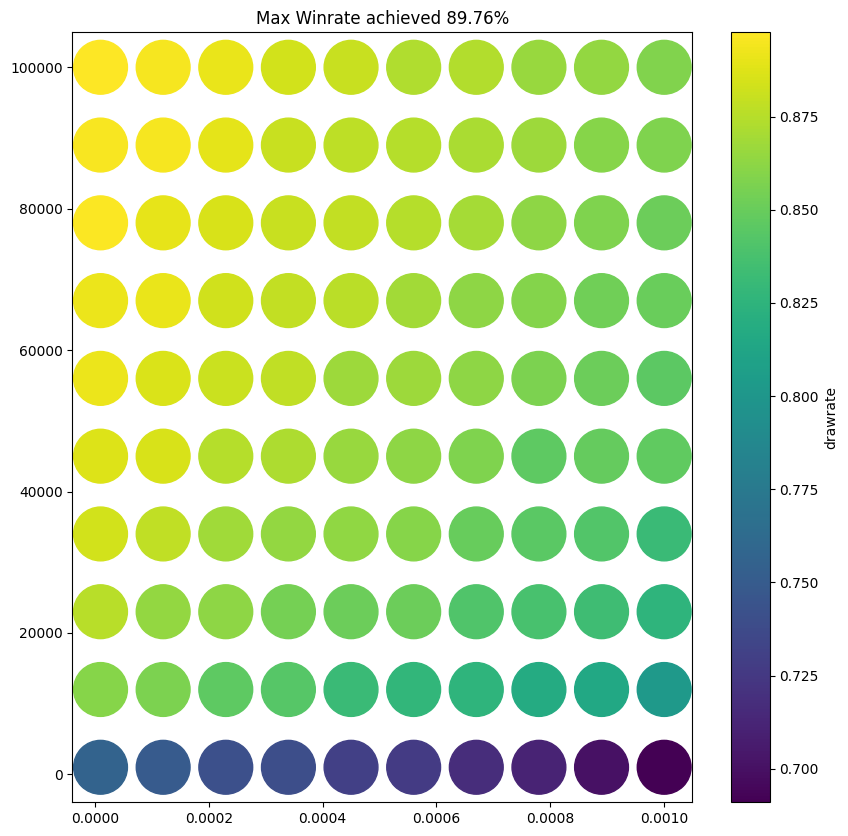

In [11]:
# 1. Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

x = df['alpha_rate']
y = df['tau_rate']
z = df['drawrate']

# 2. Capture the return value (the "mappable")
scatter = ax.scatter(x, y, c=z, s=1500, cmap='viridis') # cmap is optional but recommended

# 3. Pass the scatter object to the colorbar
fig.colorbar(scatter, ax=ax, label=z.name)
ax.set_title(f"Max Winrate achieved {z.max() * 100 :.2f}%")